In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [5]:
import json
import re

Note: in order to make it better/smoother for Github, I've commented out some of the large containers (HTML and JSON). Obviously if you download and run the notebook yourself, you can run those lines (and it's necessary for making some adjustments, e.g. see below when looking for the JSON container)

# FotMob

In [ ]:
url = 'https://www.fotmob.com/en-GB/matches/fulham-vs-manchester-united/3cqww9#4506263'
page = requests.get(url)

In [7]:
page

<Response [200]>

In [8]:
soup = BeautifulSoup(page.text,'html.parser')

In [9]:
scripts = soup.find_all('script')

scripts

[<script type="application/ld+json">{"@context":"https://schema.org","@type":"FAQPage","mainEntity":[{"@type":"Question","name":"Who won between Fulham and Manchester United on Sun, 24 Aug 2025 15:30:00 GMT?","acceptedAnswer":{"@type":"Answer","text":"Fulham vs Manchester United on Sun, 24 Aug 2025 15:30:00 GMT ended in a 1–1 tie."}}]}</script>,
 <script type="application/ld+json">{"@context":"https://schema.org","@type":"SportsEvent","sport":"Football/Soccer","homeTeam":{"@context":"https://schema.org","@type":"SportsTeam","name":"Fulham","sport":"Football/Soccer","logo":"https://images.fotmob.com/image_resources/logo/teamlogo/9879.png","url":"https://www.fotmob.com/teams/9879/overview/fulham","location":null,"memberOf":null},"awayTeam":{"@context":"https://schema.org","@type":"SportsTeam","name":"Manchester United","sport":"Football/Soccer","logo":"https://images.fotmob.com/image_resources/logo/teamlogo/10260.png","url":"https://www.fotmob.com/teams/10260/overview/manchester-united",

In [10]:
scripts

[<script type="application/ld+json">{"@context":"https://schema.org","@type":"FAQPage","mainEntity":[{"@type":"Question","name":"Who won between Fulham and Manchester United on Sun, 24 Aug 2025 15:30:00 GMT?","acceptedAnswer":{"@type":"Answer","text":"Fulham vs Manchester United on Sun, 24 Aug 2025 15:30:00 GMT ended in a 1–1 tie."}}]}</script>,
 <script type="application/ld+json">{"@context":"https://schema.org","@type":"SportsEvent","sport":"Football/Soccer","homeTeam":{"@context":"https://schema.org","@type":"SportsTeam","name":"Fulham","sport":"Football/Soccer","logo":"https://images.fotmob.com/image_resources/logo/teamlogo/9879.png","url":"https://www.fotmob.com/teams/9879/overview/fulham","location":null,"memberOf":null},"awayTeam":{"@context":"https://schema.org","@type":"SportsTeam","name":"Manchester United","sport":"Football/Soccer","logo":"https://images.fotmob.com/image_resources/logo/teamlogo/10260.png","url":"https://www.fotmob.com/teams/10260/overview/manchester-united",

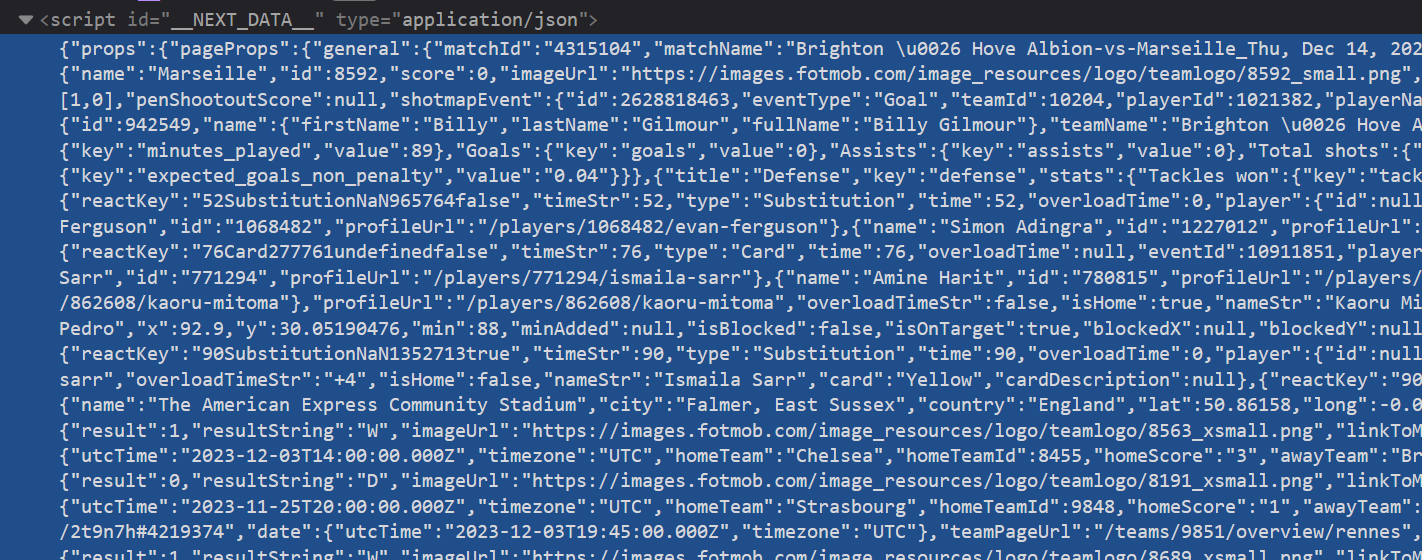

In [11]:
#this is the the specific string from the "scripts" HMTL that contains the JSON data
#this sometimes changes when you reload/rerun the Jupyter script, 
#you just have to figure out where it is in 'scripts'!
script = soup.find('script', {'id': '__NEXT_DATA__'})

In [12]:
strings = script.string
strings

'{"props":{"pageProps":{"general":{"matchId":"4813391","matchName":"Fulham-vs-Manchester United_Sun, Aug 24, 2025, 15:30 UTC","matchRound":"2","teamColors":{"darkMode":{"home":"#ffffff","away":"#C70101"},"lightMode":{"home":"#000000","away":"#C70101"},"fontDarkMode":{"home":"rgba(29, 29, 29, 1.0)","away":"rgba(255, 255, 255, 1.0)"},"fontLightMode":{"home":"rgba(255, 255, 255, 1.0)","away":"rgba(255, 255, 255, 1.0)"}},"leagueId":47,"leagueName":"Premier League","leagueRoundName":"2","parentLeagueId":47,"countryCode":"ENG","homeTeam":{"name":"Fulham","id":9879},"awayTeam":{"name":"Manchester United","id":10260},"coverageLevel":"xG","matchTimeUTC":"Sun, Aug 24, 2025, 15:30 UTC","matchTimeUTCDate":"2025-08-24T15:30:00.000Z","started":true,"finished":true},"header":{"teams":[{"name":"Fulham","id":9879,"score":1,"imageUrl":"https://images.fotmob.com/image_resources/logo/teamlogo/9879_small.png","pageUrl":"/teams/9879/overview/fulham"},{"name":"Manchester United","id":10260,"score":1,"imageUr

In [13]:
#splitting to only select the relevant match data 
#(because "strings" includes more stuff that we don't want...)
before, sep, after = strings.partition(',"seo"')

In [14]:
#before

In [15]:
def check_json_brackets(json_string):
    square_brackets = 0  # For []
    curly_brackets = 0   # For {}

    for char in json_string:
        if char == '[':
            square_brackets += 1
        elif char == ']':
            square_brackets -= 1
        elif char == '{':
            curly_brackets += 1
        elif char == '}':
            curly_brackets -= 1

    return square_brackets, curly_brackets

# Replace with your actual JSON string
json_string = before
square, curly = check_json_brackets(json_string)

print("Mismatch in square brackets: ", square)
print("Mismatch in curly brackets: ", curly)

Mismatch in square brackets:  0
Mismatch in curly brackets:  3


In [16]:
#correcting the JSON string in order to be able to parse it
before = before.replace(r'{"props":{"pageProps":','')
before = before + '}'

In [17]:
data = json.loads(before)

In [18]:
df = pd.json_normalize(data)

In [19]:
df

,nav,ongoing,hasPendingVAR,general.matchId,general.matchName,general.matchRound,general.teamColors.darkMode.home,general.teamColors.darkMode.away,general.teamColors.lightMode.home,general.teamColors.lightMode.away,...,content.table.teams,content.table.tournamentNameForUrl,content.table.parentLeagueId,content.table.countryCode,content.h2h.summary,content.h2h.matches,content.momentum.main.data,content.momentum.main.debugTitle,content.momentum.alternateModels,content.highlightStories.stories
0,"[matchfacts, liveticker, lineup, stats, table,...",False,False,4813391,"Fulham-vs-Manchester United_Sun, Aug 24, 2025,...",2,#ffffff,#C70101,#000000,#C70101,...,"[9879, 10260]",Premier League,47,ENG,"[1, 4, 16]",[{'time': {'utcTime': '2026-01-31T15:00:00.000...,"[{'minute': 0, 'value': 0}, {'minute': 1, 'val...",Using xT SA-version,[],"[{'provider': 'WSC', 'content': [{'id': '68a4c..."


In [20]:
df[["general.homeTeam.id", "general.homeTeam.name"]]

,general.homeTeam.id,general.homeTeam.name
0,9879,Fulham


In [ ]:
import requests
api_url = f'https://www.https://www.fotmob.com/api/data/matchDetails?matchId=4506263'
response = requests.get(api_url)
if response.status_code == 200:
    data = response.json()
    df = pd.json_normalize(data)

df

Establishing session...
Status: 401


In [21]:
#data.keys()

In [22]:
#data.values()

In [23]:
#data

**Lineups**

In [24]:
##I commented these JSON containers out
##since they're too large to show in Github

#this is the full container for both teams:
#data['content']['lineup']

#Brighton:
#data['content']['lineup']['lineup'][0]

#Marseille:
#data['content']['lineup']['lineup'][1]

#Brighton players container (with information and stats for each one):
#data['content']['lineup']['lineup'][0]['players']
#(the 'optaLineup' container includes the same things as the 'lineup' one!)
#data['content']['lineup']['lineup'][0]['optaLineup']['players']

In [25]:
##Below I'm showing Brighton's formation, bench and coach

#Formation
data['content']['lineup']['lineup'][0]['lineup']

KeyError: 'lineup'

In [ ]:
#Bench
data['content']['lineup']['lineup'][0]['optaLineup']['bench']

KeyError: 'lineup'

In [ ]:
#Coach
data['content']['lineup']['lineup'][0]['optaLineup']['coach']

[{'id': '42044',
  'name': {'firstName': 'Roberto',
   'lastName': 'De Zerbi',
   'fullName': 'Roberto De Zerbi'},
  'usualPosition': 5,
  'imageUrl': 'https://images.fotmob.com/image_resources/playerimages/42044.png',
  'pageUrl': '/players/42044/roberto-de-zerbi',
  'isHomeTeam': False,
  'timeSubbedOn': None,
  'timeSubbedOff': None,
  'positionRow': None,
  'role': 'Coach',
  'isCaptain': False,
  'events': {}}]

**Player profiles**

You can actually find a lot of information and stats for each player by looking/going through the 'players' dictionary within each team's 'optaLineup' container!  
*In this players dictionary, players are divided in four groups: GK, DEF, MF, FW -> "...['players'][0]" is for the goalkeeper, [1] for the defenders, [2] for the midfielders, and [3] for the forwards.  
So you then specify which player in which group you want to select, except for the GK (where there's only one player in the starting lineup). Here I show this for Igor (Brighton defender) and Adingra (Brighton forward).  
I show the detailed stats for Adingra, as well as his shotmap, as dataframes.*

In [ ]:
#Brighton's GK: Jason Steele
data['content']['lineup']['lineup'][0]['optaLineup']['players'][0]

[{'id': '107917',
  'positionId': 11,
  'position': 'Keeper',
  'positionStringShort': 'GK',
  'localizedPosition': {'label': 'GK', 'key': 'keeper'},
  'name': {'firstName': 'Jason',
   'lastName': 'Steele',
   'fullName': 'Jason Steele'},
  'shirt': 23,
  'usualPosition': 0,
  'usingOptaId': False,
  'teamId': '10204',
  'imageUrl': 'https://images.fotmob.com/image_resources/playerimages/107917.png',
  'pageUrl': '/players/107917/jason-steele',
  'isHomeTeam': False,
  'timeSubbedOn': None,
  'timeSubbedOff': None,
  'positionRow': 0,
  'role': 'Keeper',
  'events': {'yc': 1},
  'rating': {'num': '7.1',
   'bgcolor': '#1ec853',
   'isTop': {'isTopRating': False, 'isMatchFinished': True}},
  'fantasyScore': {'num': None, 'bgcolor': 'purple'},
  'minutesPlayed': 90,
  'shotmap': [],
  'stats': [{'title': 'Top stats',
    'key': 'top_stats',
    'stats': {'FotMob rating': {'key': 'rating_title', 'value': 7.09},
     'Minutes played': {'key': 'minutes_played', 'value': 90},
     'Saves': 

In [ ]:
#Brighton: Igor
data['content']['lineup']['lineup'][0]['optaLineup']['players'][1][3]

{'id': '768331',
 'positionId': 38,
 'position': 'Defender',
 'positionStringShort': 'LB',
 'localizedPosition': {'label': 'LB', 'key': 'leftback_short'},
 'name': {'firstName': '', 'lastName': 'Igor', 'fullName': 'Igor'},
 'shirt': 3,
 'usualPosition': 1,
 'usingOptaId': False,
 'teamId': '10204',
 'imageUrl': 'https://images.fotmob.com/image_resources/playerimages/768331.png',
 'pageUrl': '/players/768331/igor',
 'isHomeTeam': False,
 'timeSubbedOn': None,
 'timeSubbedOff': None,
 'positionRow': 1,
 'role': 'Defender',
 'events': {},
 'rating': {'num': '7.5',
  'bgcolor': '#1ec853',
  'isTop': {'isTopRating': False, 'isMatchFinished': True}},
 'fantasyScore': {'num': None, 'bgcolor': 'purple'},
 'minutesPlayed': 90,
 'shotmap': [],
 'stats': [{'title': 'Top stats',
   'key': 'top_stats',
   'stats': {'FotMob rating': {'key': 'rating_title', 'value': 7.46},
    'Minutes played': {'key': 'minutes_played', 'value': 90},
    'Goals': {'key': 'goals', 'value': 0},
    'Assists': {'key': '

In [ ]:
#Adingra's shotmap
data['content']['lineup']['lineup'][0]['optaLineup']['players'][3][0]['shotmap']

[{'id': 2628760769,
  'eventType': 'AttemptSaved',
  'teamId': 10204,
  'playerId': 1227012,
  'playerName': 'Simon Adingra',
  'x': 85.70882352880001,
  'y': 19.7954140155,
  'min': 7,
  'minAdded': None,
  'isBlocked': False,
  'isOnTarget': True,
  'blockedX': 102.53448275880001,
  'blockedY': 32.3225,
  'goalCrossedY': 33.77125,
  'goalCrossedZ': 0.28252631440000003,
  'expectedGoals': 0.0248645581305027,
  'expectedGoalsOnTarget': 0.0225,
  'shotType': 'LeftFoot',
  'situation': 'RegularPlay',
  'period': 'FirstHalf',
  'isOwnGoal': False,
  'onGoalShot': {'x': 1.0605158730158726,
   'y': 0.07474241121693122,
   'zoomRatio': 1},
  'isSavedOffLine': False,
  'teamColor': '#0850A0'},
 {'id': 2628771325,
  'eventType': 'AttemptSaved',
  'teamId': 10204,
  'playerId': 1227012,
  'playerName': 'Simon Adingra',
  'x': 90.8,
  'y': 20.9864968186,
  'min': 23,
  'minAdded': None,
  'isBlocked': True,
  'isOnTarget': True,
  'blockedX': 93.1,
  'blockedY': 22.177579621699998,
  'goalCrosse

In [ ]:
adingra_shots = data['content']['lineup']['lineup'][0]['optaLineup']['players'][3][0]['shotmap']
adingra_shots = pd.json_normalize(adingra_shots)
adingra_shots.rename(columns = {'eventType':'Type','isBlocked':'Blocked','isOnTarget':'On Target',
                               'expectedGoals':'xG','expectedGoalsOnTarget':'xGOT'},inplace = True)
adingra_shots.loc[:,['Type','playerName','x','y','min',
                    'Blocked','On Target','xG','xGOT',
                    'shotType','situation','blockedX','blockedY',
                    'goalCrossedY','goalCrossedZ','isSavedOffLine']]

,Type,playerName,x,y,min,Blocked,On Target,xG,xGOT,shotType,situation,blockedX,blockedY,goalCrossedY,goalCrossedZ,isSavedOffLine
0,AttemptSaved,Simon Adingra,85.708824,19.795414,7,False,True,0.024865,0.0225,LeftFoot,RegularPlay,102.534483,32.32250,33.771250,0.282526,False
1,AttemptSaved,Simon Adingra,90.800000,20.986497,23,True,True,0.022812,NaN,LeftFoot,RegularPlay,93.100000,22.17758,35.677500,1.220000,False
2,Miss,Simon Adingra,85.601471,39.124762,57,False,False,0.074018,NaN,RightFoot,RegularPlay,NaN,NaN,33.313750,4.828000,False
3,Miss,Simon Adingra,94.289474,24.209427,58,False,False,0.088350,NaN,RightFoot,RegularPlay,NaN,NaN,27.950714,4.940966,False


In [ ]:
#All of Adingra's stats
data['content']['lineup']['lineup'][0]['optaLineup']['players'][3][0]['stats']

[{'title': 'Top stats',
  'key': 'top_stats',
  'stats': {'FotMob rating': {'key': 'rating_title', 'value': 7.47},
   'Minutes played': {'key': 'minutes_played', 'value': 64},
   'Goals': {'key': 'goals', 'value': 0},
   'Assists': {'key': 'assists', 'value': 0},
   'Total shots': {'key': 'total_shots', 'value': 4},
   'Shotmap': {'key': None, 'value': True},
   'Accurate passes': {'key': 'accurate_passes', 'value': '18/23 (78%)'},
   'Chances created': {'key': 'chances_created', 'value': 2},
   'Expected goals (xG)': {'key': 'expected_goals', 'value': '0.21'},
   'Expected goals on target (xGOT)': {'key': 'expected_goals_on_target_variant',
    'value': '0.02'},
   'Expected assists (xA)': {'key': 'expected_assists', 'value': '0.17'},
   'xG + xA': {'key': 'xg_and_xa', 'value': '0.38'}}},
 {'title': 'Attack',
  'key': 'attack',
  'stats': {'Shot accuracy': {'key': 'shot_accuracy', 'value': '1/3 (33%)'},
   'Blocked shots': {'key': 'blocked_shots', 'value': 1},
   'Touches': {'key': 't

In [ ]:
#Dataframe with Adingra's 'Top Stats'
adingra_top_stats = data['content']['lineup']['lineup'][0]['optaLineup']['players'][3][0]['stats'][0]
adingra_top_df = pd.json_normalize(adingra_top_stats)
adingra_top_df

,title,key,stats.FotMob rating.key,stats.FotMob rating.value,stats.Minutes played.key,stats.Minutes played.value,stats.Goals.key,stats.Goals.value,stats.Assists.key,stats.Assists.value,...,stats.Chances created.key,stats.Chances created.value,stats.Expected goals (xG).key,stats.Expected goals (xG).value,stats.Expected goals on target (xGOT).key,stats.Expected goals on target (xGOT).value,stats.Expected assists (xA).key,stats.Expected assists (xA).value,stats.xG + xA.key,stats.xG + xA.value
0,Top stats,top_stats,rating_title,7.47,minutes_played,64,goals,0,assists,0,...,chances_created,2,expected_goals,0.21,expected_goals_on_target_variant,0.02,expected_assists,0.17,xg_and_xa,0.38


In [ ]:
adingra_top_df.rename(columns = {'stats.FotMob rating.value':'FotMob Rating','stats.Minutes played.value':
                                'Mins played','stats.Goals.value':'Goals','stats.Assists.value':'Assists',
                                'stats.Total shots.value':'Total shots','stats.Shotmap.value':'Shotmap',
                                'stats.Accurate passes.value':'Accurate passes', 'stats.Chances created.value':'Chances created',
                                'stats.Expected goals (xG).value':'xG', 'stats.Expected goals on target (xGOT).value':'xGOT',
                                'stats.Expected assists (xA).value':'xA','stats.xG + xA.value':'xG + xA'}, inplace = True)
adingra_top_df = adingra_top_df.loc[:, ['FotMob Rating', 'Mins played','Goals','Assists',
                                       'Total shots','Shotmap','Accurate passes','Chances created',
                                       'xG','xGOT','xA','xG + xA']]

In [ ]:
adingra_top_df.T

,0
FotMob Rating,7.47
Mins played,64
Goals,0
Assists,0
Total shots,4
Shotmap,True
Accurate passes,18/23 (78%)
Chances created,2
xG,0.21
xGOT,0.02


In [ ]:
#Dataframe: Adingra's attacking stats
adingra_attack_stats = data['content']['lineup']['lineup'][0]['optaLineup']['players'][3][0]['stats'][1]
adingra_attack = pd.json_normalize(adingra_attack_stats)
adingra_attack.rename(columns = {'stats.Shot accuracy.value':'Shot accuracy','stats.Blocked shots.value':
                                'Blocked shots','stats.Touches.value':'Touches','stats.Touches in opposition box.value':'Touches in opposition box',
                                'stats.Successful dribbles.value':'Successful dribbles','stats.Passes into final third.value':'Passes into final third',
                                'stats.Accurate crosses.value':'Accurate crosses', 'stats.Accurate long balls.value':'Accurate long balls',
                                'stats.Dispossessed.value':'Dispossessed', 'stats.xG Non-penalty.value':'xG Non-penalty'}, inplace = True)
adingra_attack = adingra_attack.loc[:, ['Shot accuracy','Blocked shots','Touches','Touches in opposition box',
                                       'Successful dribbles','Passes into final third','Accurate crosses',
                                       'Accurate long balls','Dispossessed','xG Non-penalty']]
adingra_attack.T

,0
Shot accuracy,1/3 (33%)
Blocked shots,1
Touches,37
Touches in opposition box,7
Successful dribbles,1/1 (100%)
Passes into final third,2
Accurate crosses,0/1 (0%)
Accurate long balls,1/2 (50%)
Dispossessed,0
xG Non-penalty,0.21


In [ ]:
#Dastaframe: Adingra's defense stats
adingra_defense_stats = data['content']['lineup']['lineup'][0]['optaLineup']['players'][3][0]['stats'][2]
adingra_defense = pd.json_normalize(adingra_defense_stats)
adingra_defense.rename(columns = {'stats.Tackles won.value':'Tackles won','stats.Clearances.value':
                                'Clearances','stats.Headed clearance.value':'Headed clearance','stats.Defensive actions.value':'Defensive actions',
                                'stats.Recoveries.value':'Recoveries'}, inplace = True)
adingra_defense = adingra_defense.loc[:, ['Tackles won','Clearances','Headed clearance','Defensive actions','Recoveries']]
adingra_defense.T

,0
Tackles won,1/1 (100%)
Clearances,1
Headed clearance,1
Defensive actions,4
Recoveries,6


In [ ]:
#Dataframe: Adingra's duel stats
adingra_duel_stats = data['content']['lineup']['lineup'][0]['optaLineup']['players'][3][0]['stats'][3]
adingra_duels = pd.json_normalize(adingra_duel_stats)
adingra_duels.rename(columns = {'stats.Duels won.value':'Duels won','stats.Duels lost.value':
                                'Duels lost','stats.Ground duels won.value':'Ground duels won',
                                'stats.Aerial duels won.value':'Aerial duels won',
                                'stats.Was fouled.value':'Was fouled',
                               'stats.Fouls committed.value':'Fouls committed'}, inplace = True)
adingra_duels = adingra_duels.loc[:, ['Duels won','Duels lost','Ground duels won',
                                      'Aerial duels won','Was fouled']]
adingra_duels.T

,0
Duels won,3
Duels lost,2
Ground duels won,3/5 (60%)
Aerial duels won,0
Was fouled,1


**Compared/Team Stats**

In [ ]:
game_stats = pd.json_normalize(data['content']['stats']['Periods']['All']['stats'])
game_stats

TypeError: 'NoneType' object is not subscriptable

In [ ]:
#Top stats
top_stats = pd.json_normalize(data['content']['stats']['Periods']['All']['stats'][0]['stats'])
top_stats

,title,key,stats,type,highlighted
0,Ball possession,BallPossesion,"[61, 39]",graph,home
1,Expected goals (xG),expected_goals,"[1.16, 0.38]",text,home
2,Total shots,total_shots,"[13, 5]",text,home
3,Shots on target,ShotsOnTarget,"[5, 0]",text,home
4,Big chances,big_chance,"[0, 0]",text,equal
5,Big chances missed,big_chance_missed_title,"[0, 0]",text,equal
6,Accurate passes,accurate_passes,"[547 (89%), 314 (82%)]",text,home
7,Fouls committed,fouls,"[15, 14]",text,away
8,Corners,corners,"[0, 2]",text,away


In [ ]:
#Shooting stats
shooting_stats = pd.json_normalize(data['content']['stats']['Periods']['All']['stats'][1]['stats'])
shooting_stats

,title,key,stats,type,highlighted
0,Shots,shots,"[None, None]",title,equal
1,Total shots,total_shots,"[13, 5]",text,home
2,Shots off target,ShotsOffTarget,"[4, 4]",text,equal
3,Shots on target,ShotsOnTarget,"[5, 0]",text,home
4,Blocked shots,blocked_shots,"[4, 1]",text,home
5,Hit woodwork,shots_woodwork,"[0, 2]",text,away
6,Shots inside box,shots_inside_box,"[7, 2]",text,home
7,Shots outside box,shots_outside_box,"[6, 3]",text,home


In [ ]:
#Expected goals stats
xG_stats = pd.json_normalize(data['content']['stats']['Periods']['All']['stats'][2]['stats'])
xG_stats

,title,key,stats,type,highlighted
0,Expected goals (xG),expected_goals,"[None, None]",title,equal
1,Expected goals (xG),expected_goals,"[1.16, 0.38]",text,home
2,xG open play,expected_goals_open_play,"[1.11, 0.37]",text,home
3,xG set play,expected_goals_set_play,"[0.04, 0.01]",text,home
4,xG non-penalty,expected_goals_non_penalty,"[1.16, 0.38]",text,home
5,xG on target (xGOT),expected_goals_on_target,"[0.44, 0.00]",text,home


In [ ]:
#Passing stats
#notice how there's not only passes here but also throws, touches in opp. box and offsides
passing_stats = pd.json_normalize(data['content']['stats']['Periods']['All']['stats'][3]['stats'])
passing_stats

,title,key,stats,type,highlighted
0,Passes,passes,"[None, None]",title,equal
1,Passes,passes,"[612, 384]",text,home
2,Accurate passes,accurate_passes,"[547 (89%), 314 (82%)]",text,home
3,Own half,own_half_passes,"[306, 212]",text,home
4,Opposition half,opposition_half_passes,"[241, 102]",text,home
5,Accurate long balls,long_balls_accurate,"[34 (67%), 22 (35%)]",text,home
6,Accurate crosses,accurate_crosses,"[3 (23%), 0 (0%)]",text,home
7,Throws,player_throws,"[23, 17]",text,home
8,Touches in opposition box,touches_opp_box,"[32, 10]",text,home
9,Offsides,Offsides,"[1, 5]",text,home


In [ ]:
#Defense stats
defense_stats = pd.json_normalize(data['content']['stats']['Periods']['All']['stats'][4]['stats'])
defense_stats

,title,key,stats,type,highlighted
0,Defence,defense,"[None, None]",title,equal
1,Tackles won,tackles_succeeded,"[5 (45%), 9 (50%)]",text,away
2,Interceptions,interceptions,"[4, 11]",text,away
3,Blocks,shot_blocks,"[1, 4]",text,away
4,Clearances,clearances,"[14, 13]",text,home
5,Keeper saves,keeper_saves,"[0, 4]",text,away


In [ ]:
#Duel stats
duel_stats = pd.json_normalize(data['content']['stats']['Periods']['All']['stats'][5]['stats'])
duel_stats

,title,key,stats,type,highlighted
0,Duels,duels,"[None, None]",title,equal
1,Duels won,duel_won,"[36, 44]",text,away
2,Ground duels won,ground_duels_won,"[32 (43%), 42 (57%)]",text,away
3,Aerial duels won,aerials_won,"[4 (67%), 2 (33%)]",text,home
4,Successful dribbles,dribbles_succeeded,"[8 (47%), 9 (50%)]",text,away


**Shotmap and Shot/xG Data**

In [ ]:
#data['content']['shotmap']

In [ ]:
shots_df = pd.json_normalize(data['content']['shotmap']['shots'])

In [ ]:
shots_df

,id,eventType,teamId,playerId,playerName,x,y,min,minAdded,isBlocked,...,isFromInsideBox,keeperId,firstName,lastName,fullName,teamColor,onGoalShot.x,onGoalShot.y,onGoalShot.zoomRatio,shortName
0,2839148675,Miss,10260,863098,Matheus Cunha,77.867476,28.118810,2,NaN,False,...,False,NaN,Matheus,Cunha,Matheus Cunha,#C70101,5.997731e-01,0.677249,0.684164,NaN
1,2839149389,Post,10260,863098,Matheus Cunha,91.600000,38.788571,2,NaN,False,...,True,NaN,Matheus,Cunha,Matheus Cunha,#C70101,1.984127e+00,0.151184,1.000000,NaN
2,2839149443,AttemptSaved,10260,1070052,Amad,95.929825,23.718981,3,NaN,True,...,True,NaN,,Amad,Amad,#C70101,7.781085e-01,0.322751,1.000000,Amad
3,2839156065,AttemptSaved,10260,422685,Bruno Fernandes,77.642233,32.246250,10,NaN,False,...,False,215168.0,Bruno,Fernandes,Bruno Fernandes,#C70101,4.957011e-01,0.225926,1.000000,NaN
4,2839158619,AttemptSaved,9879,1422593,Joshua King,94.771930,45.261911,13,NaN,False,...,True,866967.0,Joshua,King,Joshua King,#000000,1.564815e+00,0.032275,1.000000,NaN
5,2839159659,AttemptSaved,10260,863098,Matheus Cunha,94.482456,34.076250,14,NaN,False,...,True,215168.0,Matheus,Cunha,Matheus Cunha,#C70101,1.463955e+00,0.236118,1.000000,NaN
6,2839162057,AttemptSaved,9879,465750,Timothy Castagne,99.784483,42.697500,16,NaN,True,...,True,NaN,Timothy,Castagne,Timothy Castagne,#000000,4.755291e-01,0.322751,1.000000,NaN
7,2839162095,AttemptSaved,9879,604785,Alex Iwobi,86.567647,31.255000,16,NaN,False,...,False,866967.0,Alex,Iwobi,Alex Iwobi,#000000,4.957011e-01,0.096825,1.000000,NaN
8,2839162785,Miss,9879,877401,Calvin Bassey,101.017241,30.268000,17,NaN,False,...,True,NaN,Calvin,Bassey,Calvin Bassey,#000000,2.000000e+00,0.145153,0.440463,NaN
9,2839170471,AttemptSaved,9879,1422593,Joshua King,77.304369,33.618750,25,NaN,True,...,False,NaN,Joshua,King,Joshua King,#000000,1.141204e+00,0.322751,1.000000,NaN


In [ ]:
shots_df['expectedGoals']

0     0.024865
1     0.097910
2     0.015735
3     0.017694
4     0.244879
5     0.022812
6     0.106621
7     0.038355
8     0.024312
9     0.074018
10    0.088350
11    0.190031
12    0.066655
13    0.138251
14    0.012731
15    0.043690
16    0.077542
17    0.253693
Name: expectedGoals, dtype: float64

**Momentum graph values**

In [ ]:
momentum_df = pd.json_normalize(data['content']['momentum']['main']['data'])
momentum_df

,minute,value
0,0.00,0
1,1.00,0
2,2.00,0
3,3.00,-5
4,4.00,-3
...,...,...
89,88.00,71
90,89.00,54
91,90.00,49
92,90.50,3


In [ ]:
#alternative method/same data
momentum_data = pd.json_normalize(data['content']['matchFacts']['momentum']['main']['data'])
momentum_data

,minute,value
0,1.0,0
1,2.0,0
2,3.0,-5
3,4.0,-3
4,5.0,3
...,...,...
87,87.0,41
88,88.0,71
89,89.0,54
90,90.0,49


**POTM**

In [ ]:
#this is a container with info/data on FotMob's player of the match (POTM)
data['content']['matchFacts']['playerOfTheMatch']

{'id': 942549,
 'name': {'firstName': 'Billy',
  'lastName': 'Gilmour',
  'fullName': 'Billy Gilmour'},
 'teamName': 'Brighton & Hove Albion',
 'teamId': 10204,
 'rating': {'num': '7.9',
  'isTop': {'isTopRating': True, 'isMatchFinished': True}},
 'minutesPlayed': 89,
 'shotmap': [{'id': 2628792239,
   'eventType': 'AttemptSaved',
   'teamId': 10204,
   'playerId': 942549,
   'playerName': 'Billy Gilmour',
   'x': 83.8364077672,
   'y': 27.698571428000005,
   'min': 48,
   'minAdded': None,
   'isBlocked': False,
   'isOnTarget': True,
   'blockedX': 103.00862068980001,
   'blockedY': 32.6275,
   'goalCrossedY': 34.38125,
   'goalCrossedZ': 0.4879999976,
   'expectedGoals': 0.03835541382431984,
   'expectedGoalsOnTarget': 0.0229,
   'shotType': 'RightFoot',
   'situation': 'RegularPlay',
   'period': 'SecondHalf',
   'isOwnGoal': False,
   'onGoalShot': {'x': 0.8991402116402113,
    'y': 0.12910052846560846,
    'zoomRatio': 1},
   'isSavedOffLine': False,
   'teamColor': '#0850A0'}],


In [ ]:
#POTM's name
potm_name = pd.json_normalize(data['content']['matchFacts']['playerOfTheMatch']['name'])
potm_name.T

,0
firstName,Billy
lastName,Gilmour
fullName,Billy Gilmour


In [ ]:
#POTM's shotmap
potm_shots = pd.json_normalize(data['content']['matchFacts']['playerOfTheMatch']['shotmap'])
potm_shots.rename(columns = {'eventType':'Type','isBlocked':'Blocked','isOnTarget':'On Target',
                               'expectedGoals':'xG','expectedGoalsOnTarget':'xGOT'},inplace = True)
potm_shots.loc[:,['Type','playerName','x','y','min',
                    'Blocked','On Target','xG','xGOT',
                    'shotType','situation','blockedX','blockedY',
                    'goalCrossedY','goalCrossedZ','isSavedOffLine']]
potm_shots.T

,0
id,2628792239
Type,AttemptSaved
teamId,10204
playerId,942549
playerName,Billy Gilmour
x,83.836408
y,27.698571
min,48
minAdded,None
Blocked,False


In [ ]:
#POTM's stats. There are the same dictionaries as above, i.e. 'top stats', 
#attacking stats, defense stats, and so on... 
#Here I'm only showing the 'Top Stats'
potm_stats = pd.json_normalize(data['content']['matchFacts']['playerOfTheMatch']['stats'][0])
potm_stats.rename(columns = {'stats.FotMob rating.value':'FotMob Rating','stats.Minutes played.value':
                                'Mins played','stats.Goals.value':'Goals','stats.Assists.value':'Assists',
                                'stats.Total shots.value':'Total shots','stats.Shotmap.value':'Shotmap',
                                'stats.Accurate passes.value':'Accurate passes', 'stats.Chances created.value':'Chances created',
                                'stats.Expected goals (xG).value':'xG', 'stats.Expected goals on target (xGOT).value':'xGOT',
                                'stats.Expected assists (xA).value':'xA','stats.xG + xA.value':'xG + xA'}, inplace = True)
potm_stats = potm_stats.loc[:, ['FotMob Rating', 'Mins played','Goals','Assists',
                                       'Total shots','Shotmap','Accurate passes','Chances created',
                                       'xG','xGOT','xA','xG + xA']]
potm_stats.T

,0
FotMob Rating,7.94
Mins played,89
Goals,0
Assists,0
Total shots,1
Shotmap,True
Accurate passes,89/92 (97%)
Chances created,1
xG,0.04
xGOT,0.02


**Match Events/Timeline**

In [ ]:
events = pd.json_normalize(data['content']['matchFacts']['events']['events'])
events

,reactKey,timeStr,type,time,overloadTime,eventId,homeScore,awayScore,profileUrl,overloadTimeStr,...,player.id,player.name,player.profileUrl,halfStrShort,halfStrKey,injuredPlayerOut,swap,minutesAddedStr,minutesAddedKey,minutesAddedInput
0,1299780645Card535936undefinedfalse,45,Card,45,NaN,12997806.0,0,0,/players/535936/joelinton,False,...,535936.0,Joelinton,/players/535936/joelinton,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,undefined45HalfNaNundefinedundefined,45,Half,45,NaN,NaN,0,0,NaN,NaN,...,NaN,NaN,,HT,halftime_short,NaN,NaN,NaN,NaN,NaN
2,1299817758Card816325undefinedtrue,58,Card,58,NaN,12998177.0,0,0,/players/816325/boubacar-kamara,False,...,816325.0,Boubacar Kamara,/players/816325/boubacar-kamara,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1299827066Card710159undefinedtrue,66,Card,66,NaN,12998270.0,0,0,/players/710159/ezri-konsa,False,...,710159.0,Ezri Konsa,/players/710159/ezri-konsa,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,undefined78SubstitutionNaN521148false,78,Substitution,78,0.0,NaN,0,0,,False,...,NaN,NaN,,NaN,NaN,False,"[{'name': 'Jacob Murphy', 'id': '521148', 'pro...",NaN,NaN,NaN
5,undefined83SubstitutionNaN1296763false,83,Substitution,83,0.0,NaN,0,0,,False,...,NaN,NaN,,NaN,NaN,False,"[{'name': 'Lewis Miley', 'id': '1296763', 'pro...",NaN,NaN,NaN
6,undefined84SubstitutionNaN660301true,84,Substitution,84,0.0,NaN,0,0,,False,...,NaN,NaN,,NaN,NaN,False,"[{'name': 'Donyell Malen', 'id': '660301', 'pr...",NaN,NaN,NaN
7,undefined90SubstitutionNaN1258092false,90,Substitution,90,0.0,NaN,0,0,,False,...,NaN,NaN,,NaN,NaN,False,"[{'name': 'William Osula', 'id': '1258092', 'p...",NaN,NaN,NaN
8,undefined90AddedTimeNaNundefinedundefined,90,AddedTime,90,NaN,NaN,0,0,NaN,NaN,...,NaN,NaN,,NaN,NaN,NaN,NaN,+ 6 minutes added,added_injury_time,6.0
9,undefined90HalfNaNundefinedundefined,90,Half,90,NaN,NaN,0,0,NaN,NaN,...,NaN,NaN,,FT,fulltime_short,NaN,NaN,NaN,NaN,NaN


In [ ]:
#here are all the columns of the 'events' dataframe
events.columns

Index(['reactKey', 'timeStr', 'type', 'time', 'overloadTime', 'halfStrShort',
       'halfStrKey', 'player.id', 'player.profileUrl', 'profileUrl',
       'overloadTimeStr', 'isHome', 'injuredPlayerOut', 'swap', 'eventId',
       'nameStr', 'card', 'cardDescription', 'player.name', 'ownGoal',
       'goalDescription', 'goalDescriptionKey', 'suffix', 'suffixKey',
       'isPenaltyShootoutEvent', 'firstName', 'lastName', 'fullName',
       'playerId', 'newScore', 'penShootoutScore', 'assistStr',
       'assistProfileUrl', 'assistPlayerId', 'assistKey', 'assistInput',
       'shotmapEvent.id', 'shotmapEvent.eventType', 'shotmapEvent.teamId',
       'shotmapEvent.playerId', 'shotmapEvent.playerName', 'shotmapEvent.x',
       'shotmapEvent.y', 'shotmapEvent.min', 'shotmapEvent.minAdded',
       'shotmapEvent.isBlocked', 'shotmapEvent.isOnTarget',
       'shotmapEvent.blockedX', 'shotmapEvent.blockedY',
       'shotmapEvent.goalCrossedY', 'shotmapEvent.goalCrossedZ',
       'shotmapEvent.expe

***

# Understat

There is already an impressively detailed guide to scraping Understat in [José González's Understat Series](https://www.kaggle.com/josegabrielgonzalez/code), including tutorials/codes using [Beautiful Soup](https://www.kaggle.com/code/josegabrielgonzalez/understat-series-webscraping-using-beautiful-soup), [for loops](https://www.kaggle.com/code/josegabrielgonzalez/understat-series-webscraping-using-for-loops), [Selenium](https://www.kaggle.com/code/josegabrielgonzalez/understat-series-webscraping-using-selenium) and the [Understat](https://www.kaggle.com/code/josegabrielgonzalez/understat-series-understat-package) package [created by Amos Sebastian](https://understat.readthedocs.io/en/latest/).

In [ ]:
import json
import pandas as pd

**Shots Data**

In [ ]:
link = "https://understat.com/match/22284"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the shots data, it's the second script executed in order
strings = scripts[1].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
#
df_h = pd.DataFrame(data['h'])
df_a = pd.DataFrame(data['a'])
df = pd.concat([df_h,df_a])
df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,532752,10,SavedShot,0.8930000305175781,0.32,0.059324927628040314,Marcus Rashford,h,556,OpenPlay,2023,RightFoot,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Antony,Pass
1,532753,12,BlockedShot,0.794000015258789,0.655,0.019552553072571754,Alejandro Garnacho,h,10552,FromCorner,2023,RightFoot,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,None,None
2,532758,37,BlockedShot,0.9159999847412109,0.500999984741211,0.060597602277994156,Marcus Rashford,h,556,OpenPlay,2023,Head,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Aaron Wan-Bissaka,Chipped
3,532759,37,BlockedShot,0.7290000152587891,0.4179999923706055,0.016547512263059616,Bruno Fernandes,h,1228,OpenPlay,2023,LeftFoot,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Antony,Pass
4,532760,41,MissedShots,0.8980000305175782,0.7240000152587891,0.045268017798662186,Alejandro Garnacho,h,10552,OpenPlay,2023,LeftFoot,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Marcus Rashford,BallTouch
5,532761,45,BlockedShot,0.89,0.315,0.056723639369010925,Antony,h,11094,OpenPlay,2023,RightFoot,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Aaron Wan-Bissaka,Pass
6,532762,46,BlockedShot,0.88,0.3609999847412109,0.08383027464151382,Marcus Rashford,h,556,OpenPlay,2023,RightFoot,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Antony,Pass
7,532763,46,MissedShots,0.9209999847412109,0.514000015258789,0.10235649347305298,Raphael Varane,h,2245,FromCorner,2023,Head,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Bruno Fernandes,Cross
8,532767,50,BlockedShot,0.8590000152587891,0.500999984741211,0.06346779316663742,Antony,h,11094,OpenPlay,2023,LeftFoot,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Bruno Fernandes,Cross
9,532768,51,BlockedShot,0.860999984741211,0.605,0.08149542659521103,Alejandro Garnacho,h,10552,OpenPlay,2023,LeftFoot,22284,Manchester United,Wolverhampton Wanderers,1,0,2023-08-14 19:00:00,Casemiro,Pass


In [ ]:
#alternative script for the shots dataframe

url = 'https://understat.com/match/22284'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')
strings = scripts[1].string

#strip unnecessary symbols and get only JSON data 
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
data = json.loads(json_data)

#creating the shots dataframe
x = []
y = []
xG = []
result = []
team = []
data_away = data['a']
data_home = data['h']

for index in range(len(data_home)):
    for key in data_home[index]:
        if key == 'X':
            x.append(data_home[index][key])
        if key == 'Y':
            y.append(data_home[index][key])
        if key == 'h_team':
            team.append(data_home[index][key])
        if key == 'xG':
            xG.append(data_home[index][key])
        if key == 'result':
            result.append(data_home[index][key])

for index in range(len(data_away)):
    for key in data_away[index]:
        if key == 'X':
            x.append(data_away[index][key])
        if key == 'Y':
            y.append(data_away[index][key])
        if key == 'a_team':
            team.append(data_away[index][key])
        if key == 'xG':
            xG.append(data_away[index][key])
        if key == 'result':
            result.append(data_away[index][key])
col_names = ['x','y','xG','result','team']
df = pd.DataFrame([x,y,xG,result,team],index=col_names)
df = df.T

In [ ]:
df

,x,y,xG,result,team
0,0.8930000305175781,0.32,0.059324927628040314,SavedShot,Manchester United
1,0.794000015258789,0.655,0.019552553072571754,BlockedShot,Manchester United
2,0.9159999847412109,0.500999984741211,0.060597602277994156,BlockedShot,Manchester United
3,0.7290000152587891,0.4179999923706055,0.016547512263059616,BlockedShot,Manchester United
4,0.8980000305175782,0.7240000152587891,0.045268017798662186,MissedShots,Manchester United
5,0.89,0.315,0.056723639369010925,BlockedShot,Manchester United
6,0.88,0.3609999847412109,0.08383027464151382,BlockedShot,Manchester United
7,0.9209999847412109,0.514000015258789,0.10235649347305298,MissedShots,Manchester United
8,0.8590000152587891,0.500999984741211,0.06346779316663742,BlockedShot,Manchester United
9,0.860999984741211,0.605,0.08149542659521103,BlockedShot,Manchester United


In [ ]:
#And ANOTHER one: a third way to extract the shots data, using the Understat
#package created by Amos Sebastian (see understat.readthedocs.io)

In [ ]:
pip install understat

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import asyncio
import aiohttp
from understat import Understat
import nest_asyncio
# to avoid errors apply the nest asyncio 
nest_asyncio.apply()

In [ ]:
async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        match = await understat.get_match_shots(22300)
        #print(json.dumps(players)
df_a = pd.DataFrame(match['a'])
df_h = pd.DataFrame(match['h'])
df = pd.concat([df_a,df_h])
df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,534727,1,Goal,0.9130000305175782,0.4909999847412109,0.5153346061706543,Taiwo Awoniyi,a,7814,OpenPlay,2023,RightFoot,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,Morgan Gibbs-White,TakeOn
1,534728,3,Goal,0.9369999694824219,0.4879999923706055,0.09872562438249588,Willy Boly,a,6850,SetPiece,2023,Head,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,None,None
2,534737,46,BlockedShot,0.8619999694824219,0.44299999237060544,0.09796891361474991,Morgan Gibbs-White,a,6857,OpenPlay,2023,RightFoot,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,Brennan Johnson,Pass
3,534740,52,SavedShot,0.7469999694824219,0.37599998474121094,0.015222105197608471,Danilo,a,11317,OpenPlay,2023,LeftFoot,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,None,None
4,534744,60,MissedShots,0.899000015258789,0.4759999847412109,0.04851353541016579,Taiwo Awoniyi,a,7814,OpenPlay,2023,Head,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,Morgan Gibbs-White,Aerial
5,534747,79,MissedShots,0.9030000305175782,0.5129999923706055,0.04223206639289856,Taiwo Awoniyi,a,7814,SetPiece,2023,Head,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,Morgan Gibbs-White,Aerial
6,534748,82,BlockedShot,0.8109999847412109,0.5220000076293946,0.04479237645864487,Morgan Gibbs-White,a,6857,OpenPlay,2023,RightFoot,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,None,None
7,534749,83,SavedShot,0.875999984741211,0.3559999847412109,0.06066468358039856,Willy Boly,a,6850,OpenPlay,2023,RightFoot,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,Chris Wood,Pass
8,534750,88,MissedShots,0.93,0.6869999694824219,0.036899637430906296,Anthony Elanga,a,9524,FromCorner,2023,LeftFoot,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,Chris Wood,BallTouch
0,534726,0,SavedShot,0.7780000305175782,0.4129999923706055,0.030174629762768745,Antony,h,11094,OpenPlay,2023,LeftFoot,22300,Manchester United,Nottingham Forest,3,2,2023-08-26 14:00:00,Bruno Fernandes,Pass


**Player Stats**

In [ ]:
# Get the player stats, it's the second script executed in order
strings = scripts[2].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
#dataframes with players' stats
h_players = pd.DataFrame(data['h']).T
a_players = pd.DataFrame(data['a']).T
#showing the home team (Man Utd) players' stats
h_players

,id,goals,own_goals,shots,xG,time,player_id,team_id,position,player,...,yellow_card,red_card,roster_in,roster_out,key_passes,assists,xA,xGChain,xGBuildup,positionOrder
604618,604618,0,0,0,0,90,10913,89,GK,André Onana,...,0,0,0,0,0,0,0,0,0,1
604619,604619,0,0,0,0,90,5584,89,DR,Aaron Wan-Bissaka,...,0,0,0,0,3,1,0.906402587890625,1.2747522592544556,0.3683496117591858,2
604621,604621,1,0,2,0.891437828540802,90,2245,89,DC,Raphael Varane,...,0,0,0,0,0,0,0,1.0924830436706543,0.3034017086029053,3
604620,604620,0,0,0,0,48,10802,89,DC,Lisandro Martínez,...,1,0,604630,0,0,0,0,0.045268017798662186,0.045268017798662186,3
604622,604622,0,0,0,0,90,1006,89,DL,Luke Shaw,...,1,0,0,0,0,0,0,0.28685417771339417,0.28685417771339417,4
604623,604623,0,0,0,0,90,2248,89,DMC,Casemiro,...,0,0,0,0,2,0,0.3683496117591858,0.4442220628261566,0.07587243616580963,7
604624,604624,0,0,3,0.4070456027984619,79,11094,89,MR,Antony,...,0,0,604631,0,3,0,0.15970271825790405,1.497922658920288,0.9311743974685669,8
604625,604625,0,0,1,0.016547512263059616,90,1228,89,MC,Bruno Fernandes,...,0,0,0,0,3,0,0.3088981807231903,1.072768211364746,0.8496789336204529,9
604626,604626,0,0,0,0,70,7768,89,MC,Mason Mount,...,0,0,604629,0,0,0,0,0.056723639369010925,0.056723639369010925,9
604627,604627,0,0,4,0.18084846436977386,70,10552,89,ML,Alejandro Garnacho,...,0,0,604632,0,0,0,0,0.2814873456954956,0.12019143253564835,10


In [ ]:
#same with away team (Wolves)
a_players

,id,goals,own_goals,shots,xG,time,player_id,team_id,position,player,...,yellow_card,red_card,roster_in,roster_out,key_passes,assists,xA,xGChain,xGBuildup,positionOrder
604634,604634,0,0,0,0,90,9740,229,GK,José Sá,...,0,0,0,0,0,0,0,0,0,1
604635,604635,0,0,0,0,90,6163,229,DR,Nélson Semedo,...,0,0,0,0,1,0,0.0168922059237957,0.5097441077232361,0.4928519129753113,2
604636,604636,0,0,1,0.09806334227323532,90,804,229,DC,Craig Dawson,...,0,0,0,0,1,0,0.060725368559360504,0.2479642629623413,0.1872388869524002,3
604637,604637,0,0,1,0.017349420115351677,90,7332,229,DC,Max Kilman,...,0,0,0,0,1,0,0.02470371127128601,0.3707718849182129,0.3707718849182129,3
604638,604638,0,0,0,0,79,6674,229,DL,Rayan Ait Nouri,...,1,0,604646,0,1,0,0.019234422594308853,0.27060967683792114,0.2513752579689026,4
604639,604639,0,0,3,0.3071686029434204,90,6382,229,MR,Pedro Neto,...,1,0,0,0,4,0,0.6279343962669373,1.0138167142868042,0.13645930588245392,8
604641,604641,0,0,3,0.09721044450998306,90,1299,229,MC,Mario Lemina,...,1,0,0,0,0,0,0,0.1966753602027893,0.12416862696409225,9
604640,604640,0,0,1,0.017458826303482056,90,11384,229,MC,João Gomes,...,0,0,604645,0,2,0,0.12848396599292755,0.24406857788562775,0.1155846118927002,9
604642,604642,0,0,0,0,90,11000,229,ML,Matheus Nunes,...,0,0,0,0,2,0,0.029130788519978523,0.3864296078681946,0.3864296078681946,10
604644,604644,0,0,1,0.06396590173244476,65,2199,229,FW,Pablo Sarabia,...,0,0,604648,0,3,0,0.30697646737098694,0.38272371888160706,0.011781368404626846,15


In [ ]:
#alternative method: using the Understat packaage
async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        players = await understat.get_match_players(22300)
        # here you can choose the "h" to obtain the players data for the home team
        df = pd.DataFrame(players['h']).T 
df

,id,goals,own_goals,shots,xG,time,player_id,team_id,position,player,...,yellow_card,red_card,roster_in,roster_out,key_passes,assists,xA,xGChain,xGBuildup,positionOrder
606948,606948,0,0,0,0,90,10913,89,GK,André Onana,...,1,0,0,0,0,0,0,0,0,1
606949,606949,0,0,0,0,90,5584,89,DR,Aaron Wan-Bissaka,...,1,0,0,0,0,0,0,0.6768145561218262,0.6768145561218262,2
606951,606951,0,0,0,0,49,2245,89,DC,Raphael Varane,...,0,0,606959,0,0,0,0,0.03385882079601288,0.03385882079601288,3
606950,606950,0,0,0,0,90,10802,89,DC,Lisandro Martínez,...,0,0,0,0,1,0,0.01096415426582098,0.63602614402771,0.63602614402771,3
606952,606952,0,0,0,0,90,7281,89,DL,Diogo Dalot,...,0,0,0,0,0,0,0,0.0895790383219719,0.0895790383219719,4
606954,606954,1,0,1,0.16082441806793213,90,646,89,DMC,Christian Eriksen,...,0,0,0,0,2,0,0.07433079183101654,0.3208729326725006,0.08571773022413254,7
606953,606953,1,0,4,1.1162420511245728,90,2248,89,DMC,Casemiro,...,0,0,0,0,0,0,0,0.7878649830818176,0.749697208404541,7
606955,606955,0,0,4,0.15374985337257385,88,11094,89,AMR,Antony,...,0,0,606961,0,4,0,0.7180649042129517,0.8549996614456177,0.63602614402771,11
606956,606956,1,0,6,1.4227405786514282,90,1228,89,AMC,Bruno Fernandes,...,1,0,0,0,3,1,1.1082489490509033,0.7899944186210632,0.10921221971511841,12
606957,606957,0,0,2,0.10826247185468674,90,556,89,AML,Marcus Rashford,...,1,0,0,0,1,1,0.16082441806793213,0.9047237038612366,0.6725250482559204,13


**Match Info & Team Stats**

In [ ]:
response = requests.get('https://understat.com/match/22284')
match_info = re.search("match_info\s+=\s+JSON.parse\('([^']+)", response.text)
decoded_string = bytes(match_info.groups()[0], 'utf-8').decode('unicode_escape')
matchObj = json.loads(decoded_string)
df = pd.DataFrame(pd.Series(matchObj))
df

,0
id,22284
fid,1729199
h,89
a,229
date,2023-08-14 19:00:00
league_id,1
season,2023
h_goals,1
a_goals,0
team_h,Manchester United


**xG Flow Chart**

In [ ]:
link = "https://understat.com/match/22284"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')

# Get the shotsData, it's the second script executed in order
strings = scripts[1].string 

# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
shots_match = json.loads(json_data)

1. Creating the cumulative xG for each team based on the shots data

In [ ]:
import numpy as np
# Creatinf the 2 dfs

df_away = pd.DataFrame(shots_match['a'])
df_home = pd.DataFrame(shots_match['h'])

# Selecting only the useful columns

df_away = df_away[['minute','player',"a_team",'result','xG','h_a']]
df_home = df_home[['minute','player',"h_team",'result','xG','h_a']]

# Renaming columns 

df_away.rename(columns={"a_team": "team"})
df_home.rename(columns={"h_team": "team"})

# Changing data types

df_away = df_away.astype({"xG": float, "minute": float})
df_home = df_home.astype({"xG": float, "minute": float})

# Creating new column xG cumulative
df_away['xGcum'] = np.cumsum(df_away['xG'])
df_home['xGcum'] = np.cumsum(df_home['xG'])

# creating the dictionaries
x = df_home[df_home['result']=='Goal']['minute'].tolist()
x1 = df_away[df_away['result']=='Goal']['minute'].tolist()
y =df_home[df_home['result']=='Goal']['xGcum'].tolist()
y1 = df_away[df_away['result']=='Goal']['xGcum'].tolist()

# xG inside the scatterplots
y_plot =np.round(df_home[df_home['result']=='Goal']['xG'],2).tolist()
y1_plot = np.round(df_away[df_away['result']=='Goal']['xG'],2).tolist()

# Annotation text
text_home = df_home[df_home['result']=='Goal']['player'].tolist()
text_away = df_away[df_away['result']=='Goal']['player'].tolist()
label_home = df_home['h_team'].unique().tolist()
label_away = df_away['a_team'].unique().tolist()

# More annotation text
xGcum_away = str(np.round(df_away['xGcum'].iloc[-1],3))
xGcum_home = str(np.round(df_home['xGcum'].iloc[-1],3))
team_away = str(df_away['a_team'].iloc[-1])
team_home = str(df_home['h_team'].iloc[-1])

In [ ]:
df_away

,minute,player,a_team,result,xG,h_a,xGcum
0,2.0,Matheus Cunha,Wolverhampton Wanderers,BlockedShot,0.016892,a,0.016892
1,17.0,João Gomes,Wolverhampton Wanderers,BlockedShot,0.017459,a,0.034351
2,25.0,Pablo Sarabia,Wolverhampton Wanderers,BlockedShot,0.063966,a,0.098317
3,26.0,Mario Lemina,Wolverhampton Wanderers,BlockedShot,0.011781,a,0.110098
4,32.0,Matheus Cunha,Wolverhampton Wanderers,MissedShots,0.119567,a,0.229665
5,45.0,Pedro Neto,Wolverhampton Wanderers,SavedShot,0.052180,a,0.281846
6,48.0,Pedro Neto,Wolverhampton Wanderers,MissedShots,0.135229,a,0.417075
7,48.0,Matheus Cunha,Wolverhampton Wanderers,ShotOnPost,0.471496,a,0.888571
8,54.0,Matheus Cunha,Wolverhampton Wanderers,SavedShot,0.043525,a,0.932096
9,58.0,Craig Dawson,Wolverhampton Wanderers,BlockedShot,0.098063,a,1.030159


In [ ]:
df_home

,minute,player,h_team,result,xG,h_a,xGcum
0,10.0,Marcus Rashford,Manchester United,SavedShot,0.059325,h,0.059325
1,12.0,Alejandro Garnacho,Manchester United,BlockedShot,0.019553,h,0.078877
2,37.0,Marcus Rashford,Manchester United,BlockedShot,0.060598,h,0.139475
3,37.0,Bruno Fernandes,Manchester United,BlockedShot,0.016548,h,0.156023
4,41.0,Alejandro Garnacho,Manchester United,MissedShots,0.045268,h,0.201291
5,45.0,Antony,Manchester United,BlockedShot,0.056724,h,0.258014
6,46.0,Marcus Rashford,Manchester United,BlockedShot,0.083830,h,0.341845
7,46.0,Raphael Varane,Manchester United,MissedShots,0.102356,h,0.444201
8,50.0,Antony,Manchester United,BlockedShot,0.063468,h,0.507669
9,51.0,Alejandro Garnacho,Manchester United,BlockedShot,0.081495,h,0.589164


In [ ]:
xGcum_away

'1.786'

In [ ]:
xGcum_home

'1.971'

2. Plotting the Flow Chart

C:\Users\Al Raven\AppData\Local\Temp\ipykernel_22408\261076720.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [1000]
C:\Users\Al Raven\AppData\Local\Temp\ipykernel_22408\261076720.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [1000]


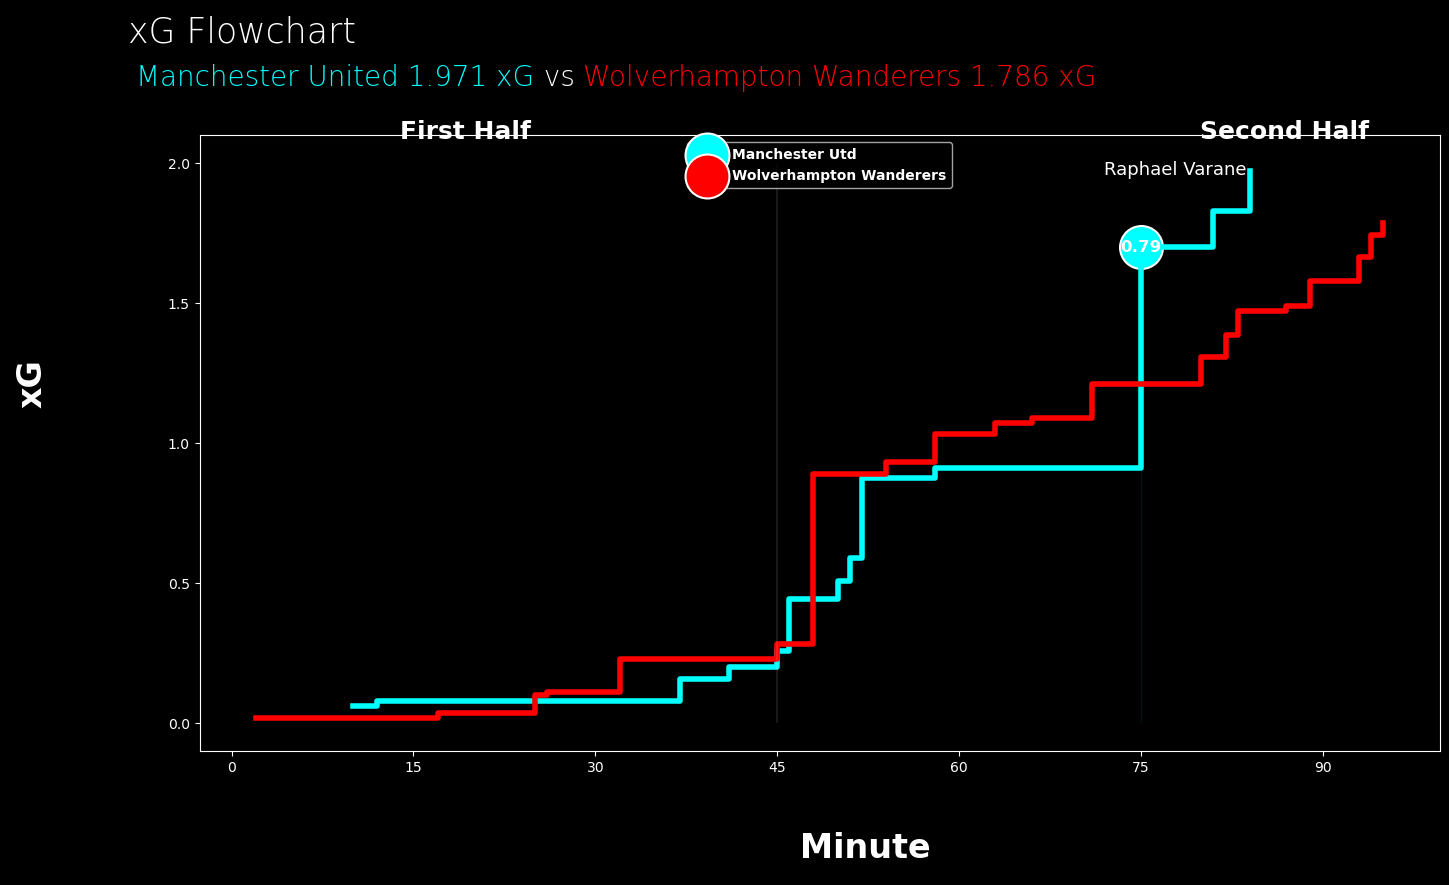

In [ ]:
import matplotlib.pyplot as plt
from highlight_text import fig_text
# plot style 
#plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
colour = 'white'
fig,ax = plt.subplots(figsize = (16,8))

# Step plot for Inter and Udinese 
ax.step(x = df_home['minute'] ,y = df_home['xGcum'] , where = 'post', color = 'cyan' ,linewidth = 4.0)
ax.step(x = df_away['minute'] ,y = df_away['xGcum'] , where = 'post', color = 'red' ,linewidth = 4.0)

#sns.scatterplot(x=x,y=y,s=430,marker='o',color='yellow')
ax.scatter(x=x,y=y, color='cyan', edgecolor=colour,s=955, label="Manchester Utd",linewidths=1.5,)
ax.scatter(x=x1,y=y1, color='red', edgecolor=colour,s=955, label="Wolverhampton Wanderers",linewidths=1.5)

#FILL AREA BETWEEN LINE AND X 
plt.fill_between(x,y, alpha=0.08, color='cyan')
plt.fill_between(x1,y1, alpha=0.08, color='red')

# Text annotation for goals
for i in range(len(x1)):
    plt.annotate(text_away[i], (x1[i]- 3, y1[i] + 0.26),c=colour,size=13)
for i in range(len(x)):
    plt.annotate(text_home[i], (x[i]- 3, y[i] + 0.26),c=colour,size=13)

# legend
legend = ax.legend(loc="upper center",prop={'weight':'bold'})
legend.legendHandles[0]._sizes = [1000]
legend.legendHandles[1]._sizes = [1000]

# title
fig_text(0.08,1.03, s="xG Flowchart\n", fontsize = 25, fontweight = "light")
fig_text(0.08,0.97, s=" <{} {} xG> vs <{} {} xG>".format(team_home,xGcum_home,team_away,xGcum_away),highlight_textprops=[{"color":'cyan'}, {'color':"red"}], fontsize = 20, fontweight="light")

# text
fig_text(0.5,0.01, s="Minute\n", fontsize = 24, fontweight = "bold", color = colour)
fig_text(0.01,0.6, s="xG\n", fontsize = 24, fontweight = "bold", color = colour,rotation=90)
fig_text(0.25,0.9, s="First Half\n", fontsize = 18, fontweight = "bold", color = colour)
fig_text(0.75,0.9, s="Second Half\n", fontsize = 18, fontweight = "bold", color = colour)

# Finally a dotted line to separate the HT 
plt.vlines( ymin=0, ymax=2,x=45, color=colour, alpha=0.1,linestyle="solid")
# ticks
plt.xticks([0,15,30,45,60,75,90])
plt.yticks([0,0.5,1,1.5,2])

# Annotate quality chances inside the scatterplots

# Home team
for i in range(len(x)):
    plt.annotate(y_plot[i], (x[i], y[i]),c=colour,size=12,ha='center',va='center',fontweight='bold')
# Away team
for i in range(len(x1)):
    plt.annotate(y1_plot[i], (x1[i], y1[i]),c=colour,size=12,ha='center',va='center',fontweight='bold')

**Match Timeline/Events**

In [ ]:
soup.find_all('div',{'class':"timiline-container"})

[<div class="timiline-container">
 <div class="timeline-left">
 <div class="timeline-block block-home">
 <div class="timeline-row">
 <a class="player-name" href="https://understat.com/player/10802">Lisandro Martínez</a> <i aria-hidden="true" class="fas fa-square yellow-card" title="Yellow card"></i>
 </div>
 </div>
 </div>
 <div class="timeline-minute">
 <span class="minute-value">16'</span>
 </div>
 <div class="timeline-right">
 <div class="timeline-block block-away">
 </div>
 </div>
 </div>,
 <div class="timiline-container">
 <div class="timeline-left">
 <div class="timeline-block block-home">
 </div>
 </div>
 <div class="timeline-minute">
 <span class="minute-value">26'</span>
 </div>
 <div class="timeline-right">
 <div class="timeline-block block-away">
 <div class="timeline-row">
 <i aria-hidden="true" class="fas fa-square yellow-card" title="Yellow card"></i> <a class="player-name" href="https://understat.com/player/1299">Mario Lemina</a>
 </div>
 </div>
 </div>
 </div>,
 <div cl

In [ ]:
timeline = soup.find_all('div',{'class':"timiline-container"})

In [ ]:
timeline[0]

<div class="timiline-container">
<div class="timeline-left">
<div class="timeline-block block-home">
<div class="timeline-row">
<a class="player-name" href="https://understat.com/player/10802">Lisandro Martínez</a> <i aria-hidden="true" class="fas fa-square yellow-card" title="Yellow card"></i>
</div>
</div>
</div>
<div class="timeline-minute">
<span class="minute-value">16'</span>
</div>
<div class="timeline-right">
<div class="timeline-block block-away">
</div>
</div>
</div>

In [ ]:
timeline[1]

<div class="timiline-container">
<div class="timeline-left">
<div class="timeline-block block-home">
</div>
</div>
<div class="timeline-minute">
<span class="minute-value">26'</span>
</div>
<div class="timeline-right">
<div class="timeline-block block-away">
<div class="timeline-row">
<i aria-hidden="true" class="fas fa-square yellow-card" title="Yellow card"></i> <a class="player-name" href="https://understat.com/player/1299">Mario Lemina</a>
</div>
</div>
</div>
</div>